# Density Based Scanning: Unsupervised Learning

By Joe Ganser

<a href="https://github.com/JoeGanser/teaching/blob/main/Lectures/unsupervised_learning/DB_Scan/db_scan.ipynb">Notebook github repo link</a>

Suppose salamanders were caught in a NJ lake and measurements of mass and length were taken of three species. Using this (fake) data, we will attempt to fit the denisty based scanning algorithm on the data.

Notebook goals
* Properly tune DB Scan on an data set
* Determine the appropriate hyperparameters (epsilon & min points)
* Make validating plots

<!-- Display the image with the specified size -->
<img src='example1.png' width="400" height="300">

### Example 1: Load & Plot the data

Make a scatter plot, like the one above, but for each species of salamander - give the graph a different color.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('db_clustering_salamanders_example1.csv',index_col=0)
def compare_x_y(data,x_axis,y_axis,legend=False):
    colors = {'species 0': (0,'red'), 'species 1': (1,'green'), 'species 2': (2,'blue')}
    for key,values in colors.items():
        plt.scatter(x=data[data['species']==values[0]][x_axis], y=data[data['species']==values[0]][y_axis], c=values[1], label=key)
    plt.xlabel(x_axis,fontsize=15)
    plt.ylabel(y_axis,fontsize=15)
    if legend:
        plt.legend(fontsize=12)
    plt.show()

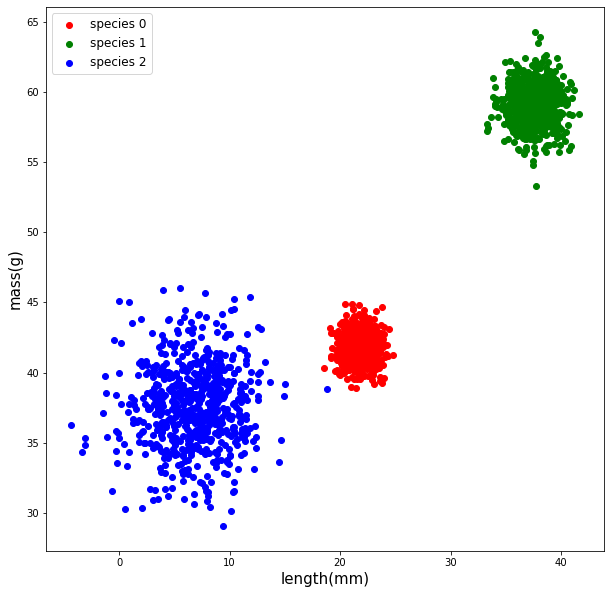

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(10,10))
compare_x_y(df,'length(mm)','mass(g)',legend=True)
plt.savefig('example1-labels.png')

### Example 2: Fit DB Scan without tuning

Fit the DB scan algorithm to the data without actually tuning it. Evaluate the results and see how the model performs.

* Use DBscan to color each point in accordance to whether its an core point, outer point or edge point
* Plot the cluster centers with stars
* Print the V score of the model
* Print the Silhoette score of the model
* Print the estimated number of noise points
* Print the estimated number of clusters

Estimated no. of clusters: 15
Estimated no. of noise points: 257
v_measure = 0.7343038605554137
silhouette_score = 0.2649627233948808


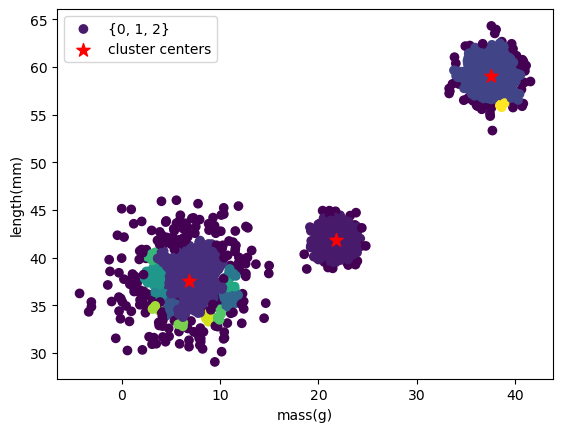

In [115]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

X = df.drop('species',axis=1)
y = df['species']
dbscan_cluster = DBSCAN()
dbscan_cluster.fit_predict(X)

# Visualizing DBSCAN
plt.scatter(X[X.columns[0]], X[X.columns[1]], c=dbscan_cluster.labels_,label=set(y))

# plot the centroids of the DB scan clusters
centroids = []
for i in range(np.max(labels) + 1):
    centroids.append(np.mean(X[labels == i], axis=0))
centroids = pd.DataFrame(np.array(centroids),columns=['mass (g)','length (mm)'])
plt.scatter(centroids['mass (g)'],centroids['length (mm)'],marker='*',s=100,label='cluster centers',c='red')

plt.xlabel("mass(g)")
plt.ylabel("length(mm)")
plt.legend()

# Number of Clusters
labels=dbscan_cluster.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(y, labels))

# Calculate silhouetteScore
print('silhouette_score =',silhouette_score(X,labels))

### Example 3: Silhouette Plots

Make a silhouette plot for each of the clusters estimated in example 1.

* Make a vertical bar representing the "overall" silhouette score of the whole data set.
* Vertically stack the horizontal silhouette scores on top of each other.
* Most clusters will be tiny, so only give the first 4 labels.
    * Give the plot a legend.

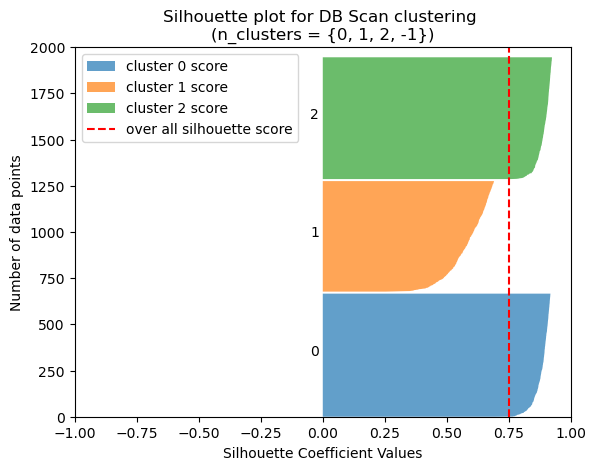

In [142]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
silhouette_scores = silhouette_samples(X, labels)

# Get the silhouette score for the entire dataset
overall_silhouette_score = silhouette_score(X, labels)

# Plot the silhouette scores for each cluster
fig, ax = plt.subplots()
ax.set_xlim([-1, 1])
ax.set_ylim([0, len(X)])

y_lower = 0
for i in range(N_clus):
    cluster_silhouette_scores = silhouette_scores[labels == i]
    cluster_silhouette_scores.sort()
    size_cluster_i = cluster_silhouette_scores.shape[0]
    y_upper = y_lower + size_cluster_i
    if i<4:
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores,
                      alpha=0.7, edgecolor='none',label='cluster {} score'.format(i))
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    elif i>6:
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores,
                      alpha=0.7, edgecolor='none')
        ax.text(-0.05, y_lower, '.')
    y_lower = y_upper + 10

ax.set_title("Silhouette plot for DB Scan clustering \n(n_clusters = {})".format(set(labels)))
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Number of data points")

ax.axvline(x=overall_silhouette_score, color="red", linestyle="--",label='over all silhouette score')
plt.legend(loc='upper left')
plt.show()

### Example 3: Determining epsilon using `KneeLocator`

Without tuning the model, we calculated the estimated number of clusters. Using the `KneeLocator` and the `NearestNeighbors` packages, use the estimated number of clusters to find the value of epsilon that makes the density drop the fastest. We will then use this as our hyperparameter when we re-tune the model.

* Fit the data to the nearest neighbors with `N_clus` (example 1) as the parameter
* Calculate the distances, sort them by the `N_clus` number of clusters
* Pass this to the `KneeLocator` function

Epsilon : 1.102447265591868


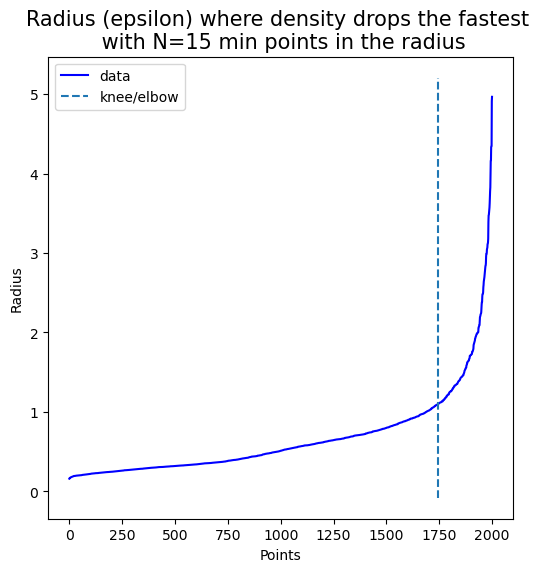

In [117]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nearest_neighbors = NearestNeighbors(n_neighbors=N_clus)
neighbors = nearest_neighbors.fit(df)

distances, indices = neighbors.kneighbors(df)
distances = np.sort(distances[:,N_clus-1], axis=0)


from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
Epsilon = distances[knee.knee]
print('Epsilon :',Epsilon)

#fig = plt.figure(figsize=(10, 10))
#plt.figure(figsize=(10, 10))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Radius")
plt.title('Radius (epsilon) where density drops the fastest \n with N={} min points in the radius'.format(N_clus),fontsize=15)
plt.show()

### Example 4: Grid searching for min points

We've determine the value of epsilon where density drops the fastest between clusters. This value of epsilon was found using 15 min points. Now we grid search around 15 points the find the best number of minimum points to fit DB scan. When we find the best number of minimum points, we should also have an optimal number of clusters - 3 - because there were only 3 in the data set to begin with.

* Loop between 5 and 15 min points, fitting DB scan using an epsilon=1.102447265
* Find the value of min points for which DB scan predicts 3 clusters AND maximimizes the overall sihlouette score.

In [133]:
scores = []
for minima in range(5,16):
    dbscan_cluster = DBSCAN(eps=distances[knee.knee], min_samples=minima)
    dbscan_cluster.fit(X)
    labels=dbscan_cluster.labels_
    N_clus=len(set(labels))-(1 if -1 in labels else 0)
    score = silhouette_score(X,labels)
    scores.append((N_clus,score,minima))
    
best = sorted([j for j in scores if j[0]==3],key=lambda x:x[1],reverse=True)[0]
print(best)
print('Best scoring min samples was: {}'.format(best[-1]))

(3, 0.74925376513721, 9)
Best scoring min samples was: 9


### Example 5: Properly fitting DB Scan

Repeat example 2 with the proper hyper parameters.

Number of min points:  11
Radius (epsilon) for DB scan:  1.102447265591868
Estimated no. of clusters: 3
Estimated no. of noise points: 74
v_measure = 0.9396202026007384
silhouette_score = 0.74925376513721


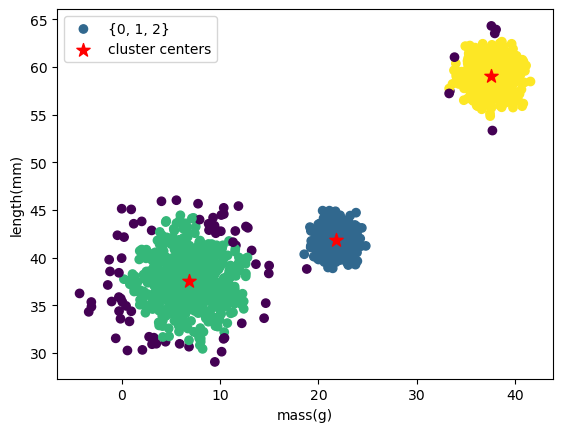

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

dbscan_cluster = DBSCAN(eps=distances[knee.knee], min_samples=best[-1])
dbscan_cluster.fit(X)

# Visualizing DBSCAN
X2 = X.copy()
X2['cluster'] = dbscan_cluster.labels_

# Visualizing DBSCAN
plt.scatter(X[X.columns[0]], X[X.columns[1]], c=dbscan_cluster.labels_,label=set(y))

# plot the centroids of the DB scan clusters
centroids = []
for i in range(np.max(labels) + 1):
    centroids.append(np.mean(X[labels == i], axis=0))
centroids = pd.DataFrame(np.array(centroids),columns=['mass (g)','length (mm)'])
plt.scatter(centroids['mass (g)'],centroids['length (mm)'],marker='*',s=100,label='cluster centers',c='red')

plt.xlabel("mass(g)")
plt.ylabel("length(mm)")
plt.legend()


print("Number of min points: ",n)
print('Radius (epsilon) for DB scan: ',distances[knee.knee])

# Number of Clusters
labels=dbscan_cluster.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(y, labels))


# Calculate silhouetteScore
print('silhouette_score =',silhouette_score(X,labels))
plt.show()

### Example 6: Well fit Silhouette plots

Repeat example 3 with the hyperparameters of example 2.

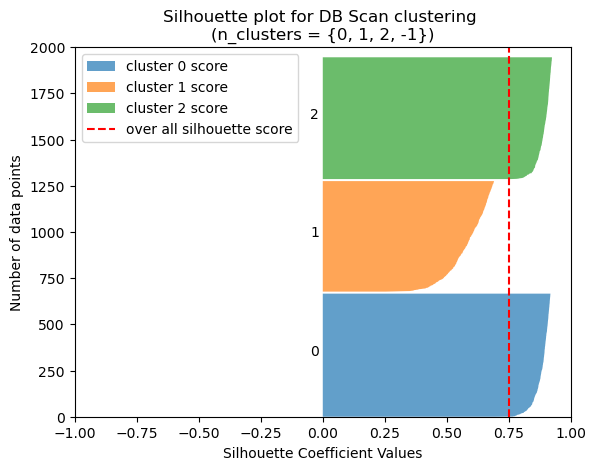

In [143]:
silhouette_scores = silhouette_samples(X, labels)

# Get the silhouette score for the entire dataset
overall_silhouette_score = silhouette_score(X, labels)

# Plot the silhouette scores for each cluster
fig, ax = plt.subplots()
ax.set_xlim([-1, 1])
ax.set_ylim([0, len(X)])

y_lower = 0
for i in range(N_clus):
    cluster_silhouette_scores = silhouette_scores[labels == i]
    cluster_silhouette_scores.sort()
    size_cluster_i = cluster_silhouette_scores.shape[0]
    y_upper = y_lower + size_cluster_i
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores,
                      alpha=0.7, edgecolor='none',label='cluster {} score'.format(i))
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title("Silhouette plot for DB Scan clustering \n(n_clusters = {})".format(set(labels)))
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Number of data points")

ax.axvline(x=overall_silhouette_score, color="red", linestyle="--",label='over all silhouette score')
plt.legend(loc='upper left')
plt.show()

### Sources

The following sources were very helpful in making this lecture;

[1] https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/